# Seq2Seq 모델링

### 1. 필요 모듈 및 데이터 로드

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from google.colab import drive

# Google Drive 연결
drive.mount('/content/drive')

# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/data_따라말하기.csv')

# 특수 토큰 추가
dialect_token = "[방언]"
standard_token = "[표준]"
start_token = '<start>'
end_token = '<end>'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. 데이터 전처리

In [ ]:
# 양방향 데이터 리스트 생성
bidirectional_data = []

for dialect, standard in zip(df['dialect'], df['standard']):
    # 방언 -> 표준어
    bidirectional_data.append({
        "source": dialect_token + " " + start_token + " " + dialect + " " + end_token,
        "target": start_token + " " + standard + " " + end_token
    })
    # 표준어 -> 방언
    bidirectional_data.append({
        "source": standard_token + " " + start_token + " " + standard + " " + end_token,
        "target": start_token + " " + dialect + " " + end_token
    })

# 토크나이저 생성
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts([item['source'] for item in bidirectional_data] + [item['target'] for item in bidirectional_data])

# 단어 사전 크기
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# 정수 시퀀스로 변환
source_seqs = tokenizer.texts_to_sequences([item['source'] for item in bidirectional_data])
target_seqs = tokenizer.texts_to_sequences([item['target'] for item in bidirectional_data])

# 패딩
max_seq_length = 64
source_seqs = pad_sequences(source_seqs, maxlen=max_seq_length, padding='post')
target_seqs = pad_sequences(target_seqs, maxlen=max_seq_length, padding='post')


In [ ]:
# 데이터 분할
train_source, val_source, train_target, val_target = train_test_split(
    source_seqs, target_seqs, test_size=0.1, random_state=42
)

### 3. Seq2Seq 모델 정의

In [ ]:
# Seq2Seq 모델 정의
embedding_dim = 256
hidden_units = 512

# 인코더 정의
encoder_inputs = Input(shape=(max_seq_length,), name='encoder_input')
encoder_embedding = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(hidden_units, return_state=True, return_sequences=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# 디코더 정의
decoder_inputs = Input(shape=(max_seq_length,), name='decoder_input')
decoder_embedding = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# 어텐션 메커니즘 정의
attention = Attention()([decoder_outputs, encoder_outputs])
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention])

# 드롭아웃 추가
decoder_concat_input = Dropout(0.5)(decoder_concat_input)

# 출력층 정의
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


In [ ]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=2e-5), loss='sparse_categorical_crossentropy')

model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64)]                 0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, 64)]                 0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 64, 256)              1186560   ['encoder_input[0][0]']       
                                                          0                                       
                                                                                                  
 embedding_9 (Embedding)     (None, 64, 256)              1186560   ['decoder_input[0][0]'] 

In [ ]:
# 체크포인트 콜백 정의
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/checkpoints/seq2seq_attention_epoch_{epoch:02d}_{val_loss:.4f}.keras',
    save_weights_only=True,
    save_freq='epoch'
)


# 모델 학습
batch_size = 32
epochs = 50
history = model.fit(
    [train_source, train_target],
    train_target,
    validation_data=([val_source, val_target], val_target),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint_callback]
)


Epoch 1/50
5454/5454 [==============================] - 562s 103ms/step - loss: 1.1425 - val_loss: 1.0628
Epoch 2/50
5454/5454 [==============================] - 562s 103ms/step - loss: 0.9712 - val_loss: 0.8876
Epoch 3/50
5454/5454 [==============================] - 562s 103ms/step - loss: 0.8017 - val_loss: 0.7248
Epoch 4/50
5454/5454 [==============================] - 559s 102ms/step - loss: 0.6516 - val_loss: 0.5858
Epoch 5/50
5454/5454 [==============================] - 562s 103ms/step - loss: 0.5310 - val_loss: 0.4781
Epoch 6/50
5454/5454 [==============================] - 563s 103ms/step - loss: 0.4401 - val_loss: 0.4015
Epoch 7/50
5454/5454 [==============================] - 563s 103ms/step - loss: 0.3734 - val_loss: 0.3452
Epoch 8/50
5454/5454 [==============================] - 563s 103ms/step - loss: 0.3232 - val_loss: 0.3027
Epoch 9/50
5454/5454 [==============================] - 563s 103ms/step - loss: 0.2846 - val_loss: 0.2695
Epoch 10/50
5454/5454 [=======================

KeyboardInterrupt: 

### 4. 모델 평가

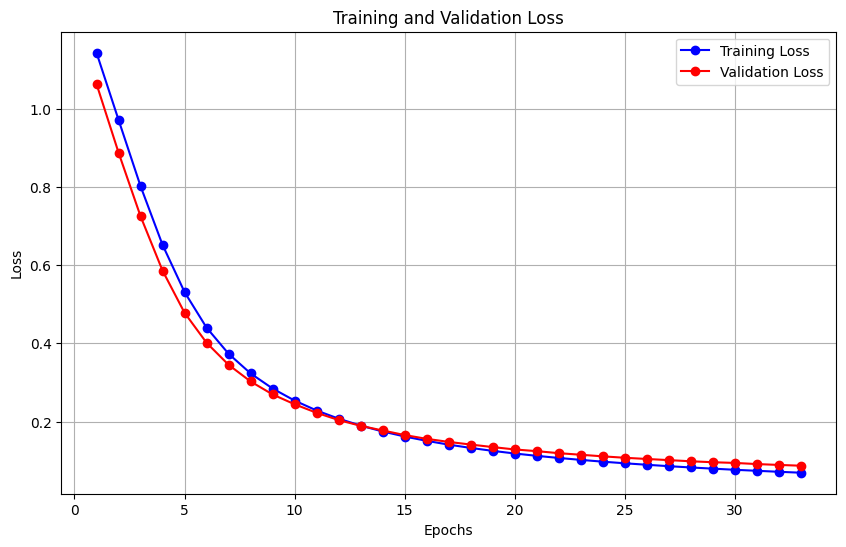

In [ ]:
import matplotlib.pyplot as plt

# 손실 값과 검증 손실 값을 리스트로 저장
train_loss = [1.1425, 0.9712, 0.8017, 0.6516, 0.5310, 0.4401, 0.3734, 0.3232, 0.2846, 0.2538, 0.2285, 0.2076, 0.1899, 0.1749, 0.1621, 0.1510, 0.1413, 0.1329, 0.1254, 0.1187, 0.1127, 0.1073, 0.1024, 0.0978, 0.0937, 0.0899, 0.0863, 0.0830, 0.0800, 0.0771, 0.0745, 0.0720, 0.0696]
val_loss = [1.0628, 0.8876, 0.7248, 0.5858, 0.4781, 0.4015, 0.3452, 0.3027, 0.2695, 0.2444, 0.2226, 0.2041, 0.1894, 0.1775, 0.1658, 0.1561, 0.1483, 0.1415, 0.1351, 0.1290, 0.1247, 0.1195, 0.1155, 0.1114, 0.1078, 0.1047, 0.1018, 0.0988, 0.0964, 0.0946, 0.0917, 0.0895, 0.0875]

# 손실 값과 검증 손실 값을 딕셔너리로 저장
history_data = {
    "loss": train_loss,
    "val_loss": val_loss
}


# 손실 값과 검증 손실 값을 리스트에서 추출
loss = history_data["loss"]
val_loss = history_data["val_loss"]

# Epoch 수를 생성
epochs = range(1, len(loss) + 1)

# 손실 시각화
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
checkpoint_path = '/content/drive/MyDrive/checkpoints/seq2seq_attention_epoch_33_0.0875.keras'

model.load_weights(checkpoint_path)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64)]                 0         []                            
                                                                                                  
 decoder_input (InputLayer)  [(None, 64)]                 0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 64, 256)              1186560   ['encoder_input[0][0]']       
                                                          0                                       
                                                                                                  
 embedding_9 (Embedding)     (None, 64, 256)              1186560   ['decoder_input[0][0]'] 

Corpus BLEU(100문장) 성능:
- 방언 -> 표준어 : 0.33
- 표준어 -> 방언 : 0.12

### 단일 문장 번역 결과 확인 

In [ ]:
# 번역 함수 정의
def translate_sentence(input_sentence, tokenizer, max_seq_length, model, token):
    input_seq = tokenizer.texts_to_sequences([token + " " + input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_seq_length, padding='post')
    translated_sentence = model.predict([input_seq, input_seq])
    translated_sentence = np.argmax(translated_sentence, axis=-1)

    # 디코딩된 문장 생성
    decoded_sentence = ''
    for token_index in translated_sentence[0]:
        if token_index == 0:
            break
        decoded_sentence += tokenizer.index_word[token_index] + ' '

    # 문장의 시작과 끝 토큰 제거 및 공백 제거
    decoded_sentence = decoded_sentence.replace('<start>', '').replace('<end>', '').strip()

    return decoded_sentence

# 특정 문장 번역 예시
input_sentence = "너 혼자 살면서 뭔 놈의 빨래를 얼마나 한다고 저런 것을 사버렸어"  # 예시 입력 문장
translated_sentence = translate_sentence(input_sentence, tokenizer, max_seq_length, model, standard_token)
print('input_sentence :', input_sentence)
print("표준어 -> 방언:", translated_sentence)

print()

input_sentence = "니 혼자 살믄서 뭔 노무 빨래를 얼마나 헌다고 저런 것을 사부렀어"  # 예시 입력 문장
translated_sentence = translate_sentence(input_sentence, tokenizer, max_seq_length, model, dialect_token)
print('input_sentence :', input_sentence)
print("방언 -> 표준어:", translated_sentence)

1/1 [==============================] - 0s 25ms/step
input_sentence : 너 혼자 살면서 뭔 놈의 빨래를 얼마나 한다고 저런 것을 사버렸어
표준어 -> 방언: 너 혼자 살면서 뭔 따로 빨래를 얼마나 한다고 저런 것을 사버렸어

1/1 [==============================] - 0s 24ms/step
input_sentence : 니 혼자 살믄서 뭔 노무 빨래를 얼마나 헌다고 저런 것을 사부렀어
방언 -> 표준어: 니 혼자 추운데 뭔 먹 빨래를 얼마나 헌다고 저런 것을 사부렀어
